In [2]:
data_final = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/suyashlakhani/tweets2")

22/12/05 06:55:08 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container marked as failed: container_1670090078315_0012_01_000001 on host: hub-msca-bdp-dphub-students-suyashlakhani-sw-xs9h.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/05 06:55:08 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 1 on hub-msca-bdp-dphub-students-suyashlakhani-sw-xs9h.c.msca-bdp-students.internal: Container marked as failed: container_1670090078315_0012_01_000001 on host: hub-msca-bdp-dphub-students-suyashlakhani-sw-xs9h.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


**3. Identify the most prolific / influential Twitterers**

**3.1 By message volume (original content)**

**3.2 By message retweet (how often their messages are being retweeted).  Please note: there are several variables that has “retweets count” in their name and you need to select correct one based on the EDA.**

**3.3 Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?**

**3.4 Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations**

In [3]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
pd.set_option("max_colwidth", 100)

from IPython.display import clear_output
clear_output(wait = False)

from google.cloud import storage

spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
print(data_final.count(),len(data_final.columns))

26921707 13


In [5]:
data_final.limit(5).toPandas()

,created_at,user,user_id,user_name,user_description,followers_count,quote_count,retweeted_status,retweet_count,favorite_count,text,verified_user,user_location
0,Wed Aug 24 17:29:41 +0000 2022,"(False, Mon Oct 04 18:02:23 +0000 2021, True, False, Pro Medical Choice, Forest bather, Outdoors...",1445086760938127372,Kevster,"Pro Medical Choice, Forest bather, Outdoors enthusiast, Respectful.",147,11,"(None, Wed Aug 24 13:42:50 +0000 2022, None, ([], None, [], [Row(display_url='twitter.com/i/web/...",88,290,"RT @AndrewLawton: ""Western knows its vaccine mandate won’t protect students. The university just...",False,None
1,Wed Aug 24 17:29:42 +0000 2022,"(False, Sun Apr 26 02:15:57 +0000 2009, False, False, Visit Our New Ruined Downtown, #maga, #Ame...",35375399,Daniel Lewis,"Visit Our New Ruined Downtown, #maga, #America First\nNo d/m's",1161,5,"(None, Wed Aug 24 17:15:05 +0000 2022, None, ([], None, [], [Row(display_url='twitter.com/i/web/...",94,334,"RT @StephenM: Here’s what we should do re: college debt — tax university endowments, using the f...",False,Sarasota Florida
2,Wed Aug 24 17:29:42 +0000 2022,"(False, Wed Oct 13 02:30:05 +0000 2021, True, False, Check out the recent history of the grossly...",1448113670802837514,"William Turner, PhD, JD",Check out the recent history of the grossly degraded Republican Party in my new book: https://ww...,521,31,"(None, Tue Aug 23 20:14:22 +0000 2022, None, ([], None, [], [Row(display_url='twitter.com/i/web/...",1198,9651,"RT @fuckyouiquit: If they cancelled all student debt, made college free, and gave everyone unive...",False,"Ph.D. US History, JD"
3,Wed Aug 24 17:29:42 +0000 2022,"(False, Sat Mar 19 18:51:25 +0000 2022, True, False, @SFSU ‘07 | Healing with essential oils | G...",1505255578163056644,Cari🌿,@SFSU ‘07 | Healing with essential oils | Gallbladder removed June. Supporter of HRH Princess Be...,13,0,None,0,0,@SenRonJohnson Republicans also went to college and will benefit from this announcement from POT...,False,None
4,Wed Aug 24 17:29:43 +0000 2022,"(False, Mon Jul 04 20:50:56 +0000 2022, True, False, #BreakTheSilence, 6130, 46, 45, False, 1544...",1544060980656840704,Tefera Degefu,#BreakTheSilence,46,2,"(None, Wed Aug 24 15:43:34 +0000 2022, None, ([], None, [], [Row(display_url='twitter.com/i/web/...",40,31,"RT @Sultan_Abagissa: The TPLF, which has no notion of peace, took advantage of the chance to for...",False,None


3. Identifying the most prolific/influential tweets 

In [50]:
influence_df = data_final.select([data_final.user_id, 
                                         data_final.user_name,
                                  data_final.user_description,
                                       data_final.retweeted_status,
                                       data_final.retweet_count,
                                       data_final.quote_count,
                                  data_final.followers_count,
                                  data_final.verified_user,
                                       data_final.favorite_count])

3.1 By message volume (original content)

In [7]:
#By message volume

mess_vol_count = influence_df.groupBy('user_id').count().orderBy('count',ascending=False)

In [8]:
# User_ID vs Count(Message volume)
mess_vol_count.show(10)

+-------------------+-----+
|            user_id|count|
+-------------------+-----+
|1463182041147576321|19840|
|1422259384525090818|19811|
|1128225338775953408|11591|
|1549115944735481856| 9357|
|          219401992| 9236|
|1322084295507259392| 8531|
|1323262598591074307| 8367|
|1508968207259869185| 8345|
|1483749445900861446| 7957|
|1295715136141963267| 7431|
+-------------------+-----+
only showing top 10 rows



In [37]:
# User_name vs Count(Message volume)
mess_vol_count_un = influence_df.groupBy('user_name').count().orderBy('count',ascending=False)
mess_vol_count_un.show(10)

+------------------+-----+
|         user_name|count|
+------------------+-----+
|                 .|22450|
|High School.sports|14720|
|           sport99|14698|
|                 ً|13586|
|  hsgameupdatenews|12221|
|    Dennis Stemmle| 9236|
|              JEAN| 8372|
|             Chris| 7630|
|              Alex| 7508|
|              Mike| 7441|
+------------------+-----+
only showing top 10 rows



In [25]:
influence_df.dtypes

[('user_id', 'bigint'),
 ('user_name', 'string'),
 ('retweeted_status',
  'struct<coordinates:struct<coordinates:array<double>,type:string>,created_at:string,display_text_range:array<bigint>,entities:struct<hashtags:array<struct<indices:array<bigint>,text:string>>,media:array<struct<additional_media_info:struct<description:string,embeddable:boolean,monetizable:boolean,title:string>,description:string,display_url:string,expanded_url:string,id:bigint,id_str:string,indices:array<bigint>,media_url:string,media_url_https:string,sizes:struct<large:struct<h:bigint,resize:string,w:bigint>,medium:struct<h:bigint,resize:string,w:bigint>,small:struct<h:bigint,resize:string,w:bigint>,thumb:struct<h:bigint,resize:string,w:bigint>>,source_status_id:bigint,source_status_id_str:string,source_user_id:bigint,source_user_id_str:string,type:string,url:string>>,symbols:array<struct<indices:array<bigint>,text:string>>,urls:array<struct<display_url:string,expanded_url:string,indices:array<bigint>,url:string>

3.2 By message retweet (how often their messages are being retweeted).  Please note: there are several variables that has “retweets count” in their name and you need to select correct one based on the EDA.

In [9]:
#By message retweet
#User_id vs retweet count
retw_vol_count = influence_df.groupBy('user_id').agg(sum('retweet_count')).orderBy("sum(retweet_count)",ascending=False)

retw_vol_count.show(10)

+-------------------+------------------+
|            user_id|sum(retweet_count)|
+-------------------+------------------+
|1501043135639695367|           2547926|
|1213469998103973888|           1906696|
|          362084030|           1617142|
|1256092281473339392|           1442123|
|1179428009788489728|           1404112|
| 799259312828850178|           1354220|
|         2378324935|           1319245|
|          804430039|           1179269|
|1262521651717189634|           1160031|
| 898231845925646336|           1116262|
+-------------------+------------------+
only showing top 10 rows



In [10]:
#User_name vs retweet count

retw_vol_count_un = influence_df.groupBy('user_name').agg(avg('retweet_count')).orderBy("avg(retweet_count)",ascending=False)

retw_vol_count_un.show(10)

+--------------------+------------------+
|           user_name|avg(retweet_count)|
+--------------------+------------------+
|       K33mi3_Nicca❤|          516928.0|
|cece (manifesting...|          516614.0|
|                 no…|          516593.0|
|   𝒩𝑒𝓅𝒽𝑒𝓁𝑒 🍯|          516556.0|
|            Ch3wb0ca|          516555.0|
|Meer 🌊 || hiatus...|          516539.0|
|👑King Riki | Deb...|          516534.0|
|Fenrisúlfr Hróðvi...|          516534.0|
| LilactheFairyDragon|          516532.0|
|💫TaurosLumen💫PN...|          516530.0|
+--------------------+------------------+
only showing top 10 rows



3.3 Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?

In [ ]:
#Who are these twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)

influence_df = influence_df.withColumn("retweet_quote_count", col("retweet_count")+col("quote_count"))\
    .withColumn("total_engagement", col("retweet_count")+col("quote_count")+col("favorite_count"))

inf_df_joined = influence_df.join(mess_vol_count, "user_id" ,"left")
inf_df_joined = inf_df_joined.withColumn("total_influence", (col("retweet_quote_count")/col("total_engagement")) * col("count"))

inf_df_joined.limit(5).toPandas()

22/12/05 08:07:58 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 61 for reason Container marked as failed: container_1670090078315_0012_01_000062 on host: hub-msca-bdp-dphub-students-suyashlakhani-sw-vbql.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/05 08:07:58 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 60 for reason Container marked as failed: container_1670090078315_0012_01_000061 on host: hub-msca-bdp-dphub-students-suyashlakhani-sw-vbql.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/05 08:07:58 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 61 on hub-msca-bdp-dphub-students-suyashlakhani-sw-vbql.c.msca-bdp-students.internal: Container marked as failed: container_1670090078315_0012_01_000062 on 

,user_id,user_name,user_description,retweeted_status,retweet_count,quote_count,followers_count,verified_user,favorite_count,retweet_quote_count,total_engagement,count,total_influence
0,10422,there is no spoon,i like buying records. and donuts.,None,0,0,1116,False,0,0,0,2,NaN
1,10422,there is no spoon,i like buying records. and donuts.,None,0,0,1128,False,0,0,0,2,NaN
2,15663,Kim Plowright,I need a new bio but I have no idea who I am any more. Possibly an artist? So tired of extremely...,None,0,0,2262,False,0,0,0,1,NaN
3,266883,Phil Spray,Digital content | School governor | Dad of three | Husband | He/him,None,0,0,1658,False,0,0,0,1,NaN
4,276813,Nandini (she),Writer-in-hiding. Watch this space.,None,0,0,238,False,0,0,0,1,NaN


In [52]:
inf_df_joined = inf_df_joined.na.fill(value=0,subset=["total_influence"])

In [25]:
inf_df_joined.count()

26921707

In [ ]:
df_null_inf = inf_df_joined.select([F.count(F.when(inf_df_joined[c].isNull(), c)).alias(c) for c in inf_df_joined.columns]).toPandas()
df_null_inf

In [57]:
inf_df_joined = inf_df_joined.withColumn("Organization",
                        F.when(inf_df_joined.verified_user == 'false', 'Other') \
                        .when((inf_df_joined.user_description.contains('university'))
                              | (inf_df_joined.user_name.contains('university')) 
                              | (inf_df_joined.user_name.contains('University')) 
                              | (inf_df_joined.user_name.contains('School of')), 'University')
                        .when((inf_df_joined.user_description.contains('school')) 
                              | (inf_df_joined.user_name.contains('school')) 
                              | (inf_df_joined.user_name.contains('School')) , 'School')  
                        .when((inf_df_joined.user_description.contains('nonprofit organization')), 'nonprofit organization')                             
                        .when((inf_df_joined.user_description.contains('gov')) 
                              | (inf_df_joined.user_name.contains('gov')) 
                              | (inf_df_joined.user_name.contains('Department of')) \
                              | (inf_df_joined.user_description.contains('president'))
                              | (inf_df_joined.user_name.contains('president')) \
                              | (inf_df_joined.user_description.contains('senat')) 
                              | (inf_df_joined.user_name.contains('senat')) \
                              | (inf_df_joined.user_description.contains('congress')) 
                              | (inf_df_joined.user_name.contains('congress')) \
                              | (inf_df_joined.user_description.contains('prime minister'))
                              | (inf_df_joined.user_name.contains('prime minister')) \
                              | (inf_df_joined.user_description.contains('parliament')) 
                              | (inf_df_joined.user_name.contains('parliament')) \
                              | (inf_df_joined.user_description.contains('vp')) 
                              | (inf_df_joined.user_name.contains('vp')) \
                              | (inf_df_joined.user_description.contains('white house')) 
                              | (inf_df_joined.user_name.contains('white house')) \
                              | (inf_df_joined.user_description.contains('mayor')) 
                              | (inf_df_joined.user_name.contains('mayor')) \
                              | (inf_df_joined.user_description.contains('democr')) 
                              | (inf_df_joined.user_name.contains('democr')) \
                              | (inf_df_joined.user_description.contains('republic')) 
                              | (inf_df_joined.user_name.contains('republic')), 'Government') \
                        .when((inf_df_joined.user_description.contains('news')) 
                              | (inf_df_joined.user_name.contains('news')) \
                              | (inf_df_joined.user_description.contains('News')) 
                              | (inf_df_joined.user_name.contains('News')) \
                              | (inf_df_joined.user_description.contains('daily')) 
                              | (inf_df_joined.user_name.contains('daily')) \
                              | (inf_df_joined.user_description.contains('times')) 
                              | (inf_df_joined.user_name.contains('times')) \
                              | (inf_df_joined.user_description.contains('journal')) 
                              | (inf_df_joined.user_name.contains('journal')), 'News') \
                        .when(((inf_df_joined.user_description.contains('actor')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('singer')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('writer')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('play')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('musician')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('actress')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('golfer')) & (inf_df_joined.followers_count > 10000)) \
                              | ((inf_df_joined.user_description.contains('author')) & (inf_df_joined.followers_count > 10000)), 'Celebrity') \
                        .when(inf_df_joined.followers_count >= 5000, 'Influencer'))   
              

In [58]:
inf_df_joined = inf_df_joined.na.fill(value='Other',subset=["Organization"])

inf_df_joined.limit(5).toPandas()

22/12/05 08:26:16 WARN org.apache.spark.network.server.TransportChannelHandler: Exception in connection from /10.128.0.9:35846
java.io.IOException: Connection timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:253)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1133)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:148)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:714)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:650)
	at io.netty.channel.nio.NioEventLoop.proces

,user_id,user_name,user_description,retweeted_status,retweet_count,quote_count,followers_count,verified_user,favorite_count,retweet_quote_count,total_engagement,count,total_influence,Organization
0,10422,there is no spoon,i like buying records. and donuts.,None,0,0,1116,False,0,0,0,2,0.0,Other
1,10422,there is no spoon,i like buying records. and donuts.,None,0,0,1128,False,0,0,0,2,0.0,Other
2,15663,Kim Plowright,I need a new bio but I have no idea who I am any more. Possibly an artist? So tired of extremely...,None,0,0,2262,False,0,0,0,1,0.0,Other
3,266883,Phil Spray,Digital content | School governor | Dad of three | Husband | He/him,None,0,0,1658,False,0,0,0,1,0.0,Other
4,276813,Nandini (she),Writer-in-hiding. Watch this space.,None,0,0,238,False,0,0,0,1,0.0,Other


In [79]:
inf_df_joined.count()

26921707

In [80]:
inf_df_joined = inf_df_joined.dropDuplicates(['user_id'])

In [81]:
inf_profile = inf_df_joined.groupby("Organization").count().orderBy('count',ascending=False).toPandas()

inf_profile

,Organization,count
0,Other,7257743
1,Influencer,36762
2,News,18533
3,Government,2596
4,Celebrity,1440
5,School,1280
6,University,880
7,nonprofit organization,24


--> This gives us a rough idea of who these twitterers are. 

3.4 Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

<AxesSubplot:xlabel='count', ylabel='Organization'>

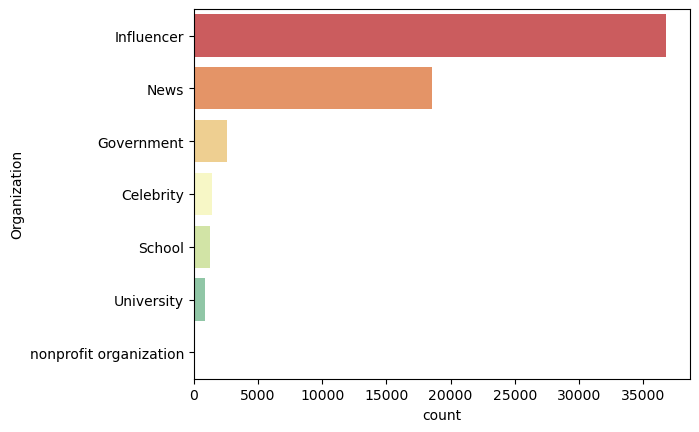

In [82]:
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.tight_layout()
sns.barplot(y="Organization",x="count",data=inf_profile[1:],palette="Spectral")

-->We can see that the Influencers and News channels have the highest number of tweets 

In [ ]:
inf_profile_tweetcount = inf_df_joined.groupby("Organization").sum("count").orderBy('sum(count)',ascending=False).toPandas()


In [84]:
inf_profile_tweetcount

,Organization,sum(count)
0,Other,26420503
1,Influencer,227340
2,News,210581
3,School,27403
4,Government,14821
5,University,10973
6,Celebrity,9906
7,nonprofit organization,180


<AxesSubplot:xlabel='sum(count)', ylabel='Organization'>

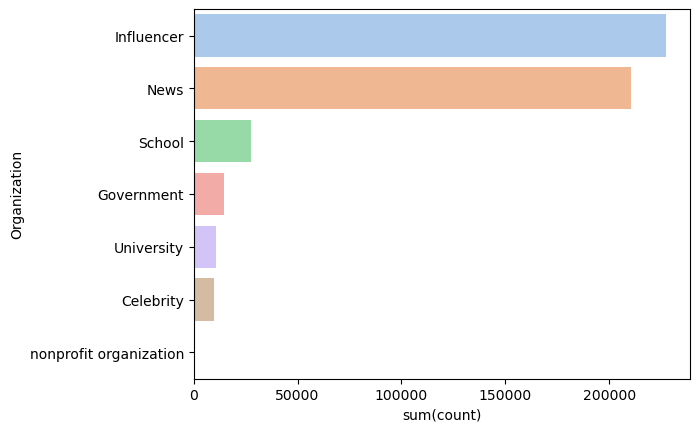

In [85]:
plt.tight_layout()
sns.barplot(y="Organization",x="sum(count)",data=inf_profile_tweetcount[1:],palette="pastel")

In [86]:
inf_profile_avgcount = inf_df_joined.groupby("Organization").avg("count").orderBy('avg(count)',ascending=False).toPandas()
inf_profile_avgcount

,Organization,avg(count)
0,School,21.273930
1,University,12.419134
2,News,11.378700
3,nonprofit organization,7.500000
4,Celebrity,6.495495
5,Influencer,6.178296
6,Government,5.813416
7,Other,3.640385


<AxesSubplot:xlabel='avg(count)', ylabel='Organization'>

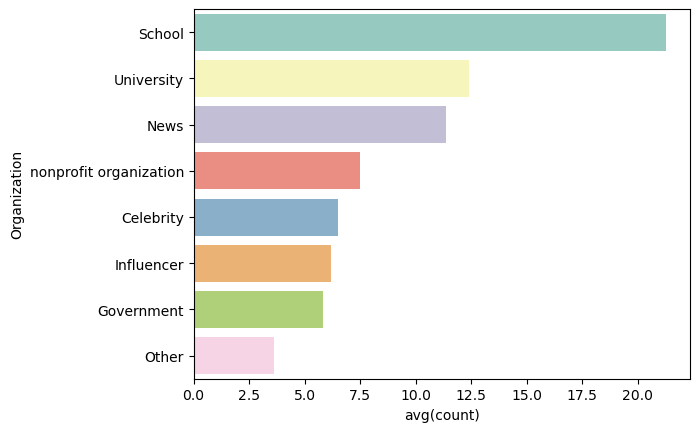

In [87]:
plt.tight_layout()
sns.barplot(y="Organization",x="avg(count)",data=inf_profile_avgcount[:],palette="Set3")

--> On an average, Schools and Universities tweet the maximum number of times among other Twitterers group

In [88]:
inf_profile_retweet = inf_df_joined.groupby("Organization").avg('retweet_count').orderBy("avg(retweet_count)",ascending=False).toPandas()
inf_profile_retweet

,Organization,avg(retweet_count)
0,Other,2323.642923
1,Celebrity,762.640193
2,Influencer,494.500014
3,News,373.752308
4,School,293.508607
5,Government,190.592821
6,nonprofit organization,42.875000
7,University,27.676471


<AxesSubplot:xlabel='avg(retweet_count)', ylabel='Organization'>

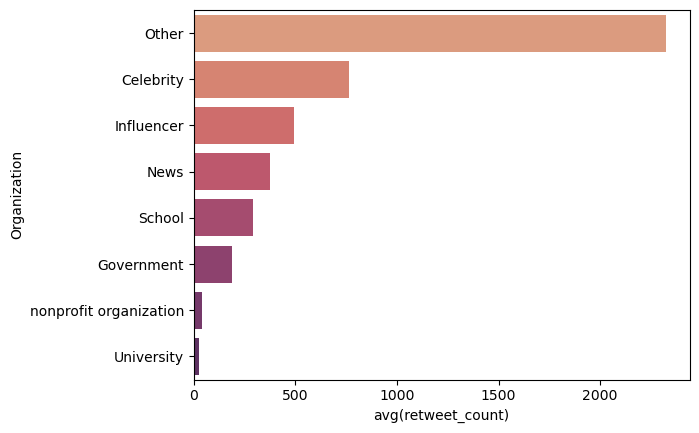

In [89]:
plt.tight_layout()
sns.barplot(y="Organization",x="avg(retweet_count)",data=inf_profile_retweet[:],palette="flare")

--> We can see that the Celebrities and Influencers have the maximum number of retweets for their tweets (This can easily be explained by their popularity)

In [90]:
inf_profile_retweet_sum = inf_df_joined.groupby("Organization").sum('retweet_count').orderBy("sum(retweet_count)",ascending=False).toPandas()
inf_profile_retweet_sum

,Organization,sum(retweet_count)
0,Other,16855286219
1,Influencer,17227039
2,News,7044376
3,Celebrity,1440332
4,Government,537171
5,School,380053
6,University,10677
7,nonprofit organization,1019


<AxesSubplot:xlabel='sum(retweet_count)', ylabel='Organization'>

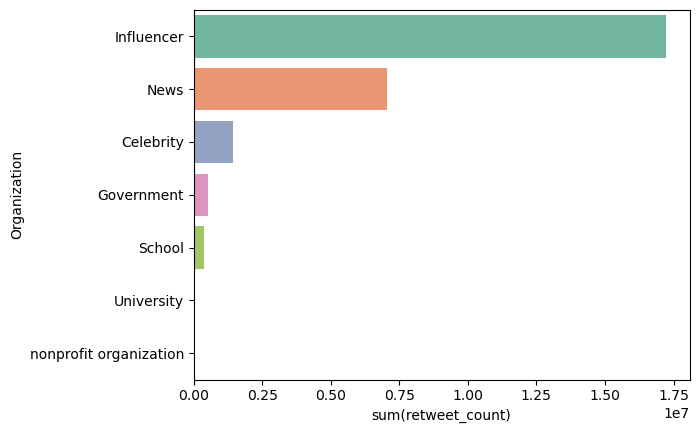

In [91]:
plt.tight_layout()
sns.barplot(y="Organization",x="sum(retweet_count)",data=inf_profile_retweet_sum[1:],palette="Set2")

--> Since News channels tweet a lot, their retweet count is high as well(sum). But on an average, Influencers and celebrities have the highest retweet count per tweet

In [92]:
inf_df_joined.write.format("parquet").mode('overwrite').save('gs://msca-bdp-students-bucket/shared_data/suyashlakhani/tweets3')